# PHYS 309 Final Data Analysis 3

Similar to PHYS 309 Final Data Analysis 1, but trying with only one set of fixed peak limits that certainly encompasses the entire peak.

NOTE: This is the actual final data analysis used in my report.

November 29, 2017

In [1]:
# Some math and stats functions I'll need
%pylab inline
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.stats import sem

# Make my plots prettier
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_context('paper', font_scale=1.8)
%config InlineBackend.figure_format = 'retina'

# For loading and sorting my data
from os import listdir
from natsort import natsorted
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define some useful functions I'll use many times
def load_data(dir_regex_str, pol_t_path):
    """Load the data from the directory selected by dir_regex_str and the pol_t_path
    INPUTS:
        - (String) dir_regex_str: Regex expression to find the directory with all the data for one concentration of salt.
        - (String)    pol_t_path: Relative path to a file containing the polarization times used.
    OUTPUTS:
        - (3D numpy array) data: the time domain signal for each run and polarization time.
        - (numpy array)   pol_t: array of polarization times used in ms.
    """
    
    data_dirs = natsorted(glob.glob(dir_regex_str))
    data_sets = [natsorted(glob.glob(ds + '/data*')) for ds in data_dirs]
    data = []
    for data_set in data_sets:
        data.append([np.loadtxt(f) for f in data_set])

    pol_t = loadtxt(pol_t_path) / 1000  # convert from ms to s
    return data, pol_t

In [3]:
def model(t, T1, M0, d):
    """Exponential model for fitting signal strength vs polarization time."""
    return M0 * (1-exp(-t/T1)) + d

In [4]:
def get_T1(data, pol_t, peak_lims, p0,
           plt_fit=True, plt_residuals=True):
    """Return the estimated T1 time.
     - data (array): time domain signal for each polarization time and each trial.
     - pol_t (array): array of polarization times
     - peak_lims: estimated peak limits
     - peak_width: peak width around maximum
    """
    peak_areas = zeros((shape(data)[0], len(pol_t))) # (n trials) x (n polarization times)
    for tr in range(shape(data)[0]): # for each trial
        for pt in range(len(pol_t)):  # for each polarization time
            # Calculate the discrete fourier transform and frequency
            F = fft.fft(data[tr][pt])
            freq = fft.fftfreq(len(F), .0001)  # each step is 0.0001ms
            
            s = logical_and(freq > peak_lims[0], freq < peak_lims[1])
            peak_areas[tr][pt] = simps(abs(F[s]), freq[s])  # calculate the area under the peak using simpson's rule

    avg_peak_areas = mean(peak_areas, axis=0)
    err_peak_areas = sem(peak_areas, axis=0)

    popt, pcov = curve_fit(model, pol_t, avg_peak_areas, sigma=err_peak_areas, p0=p0)
    T1 = popt[0]
    uT1 = sqrt(diag(pcov))[0]

    model_pnts = model(pol_t, *popt)
    r_chi2 = reduced_chi2(peak_areas, pol_t, popt)

    if plt_fit:
        plot_fit(pol_t, avg_peak_areas, err_peak_areas, popt)
    if plt_residuals:
        plot_residuals(pol_t, avg_peak_areas, err_peak_areas, popt)
        
    return T1, uT1, r_chi2, popt, pcov

def reduced_chi2(peak_areas, pol_t, popt):  
    """  
    Return the reduced chi squared statistic.
    """
    data = mean(peak_areas, axis=0)
    sigma2 = var(peak_areas, axis=0)
    expected = model(pol_t, *popt)
    nu = len(data) - 3  # 3 free parameters in my model 

    chi2 = numpy.sum(((data-expected)**2/sigma2))           
        
    return chi2 / nu       

                     
def plot_ffts(pol_t, data, xlims, ylims):
    """Plot the Fourier transforms of the data with a separate figure for each trial."""
    cmap = plt.get_cmap('jet')  # colors for the plots 
    for m in range(shape(data)[0]): # for each trial
        figure()
        for n in range(len(pol_t)):  # for each polarization time
            F = fft.fft(data[m][n])
            freq = fft.fftfreq(len(F), .0001)  # each step is 0.0001s
            
            c = cmap(float(n)/len(pol_t))
            plot(freq, abs(F), color=c)
            
        xlim(xlims)  # Hz
        ylim(ylims)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        xlabel('Frequency (Hz)')
        ylabel('Spectrum')
                     
    
def plot_peak_lims(pol_t, data, peak_lims, ylims):
    """Plot the FFT with the peak limits to use"""
    for m in range(shape(data)[0]):
        figure()
        F = fft.fft(data[m][-1])
        freq = fft.fftfreq(len(F), .0001)  # each step is 0.0001ms
        plot(freq, abs(F))
 
        axvline(peak_lims[0], linestyle='--', color='r')
        axvline(peak_lims[1], linestyle='--', color='r')
            
        xlim([peak_lims[0]-10, peak_lims[1]+10])  # kHz
        ylim(ylims)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        xlabel('Frequency (Hz)')
        ylabel('Spectrum')
    
                     
def plot_fit(pol_t, avg_peak_areas, err_peak_areas, popt):
    """Plot the data with the best model fit."""
    figure()
    x = linspace(0,10,100)
    scatter(pol_t, avg_peak_areas, s=15)
    errorbar(pol_t, avg_peak_areas, err_peak_areas, linestyle='None')
    plot(x, model(x, *popt))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    xlabel('Polarization time (s)')
    ylabel('Signal Strength (Area under the peak)')

                     
def plot_residuals(pol_t, avg_peak_areas, err_peak_areas, popt):
    figure()
    residuals = avg_peak_areas - model(pol_t, *popt)
    scatter(pol_t, residuals)
    errorbar(pol_t, residuals, err_peak_areas, linestyle='None')
    hlines(0, 0, 10, colors='r')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    xlabel('Polarization Time (s)')
    ylabel('Residuals')

## Plain tap water

In [5]:
data0, pol_t0 = load_data('./nov1/*', './nov1/set1/array.txt')

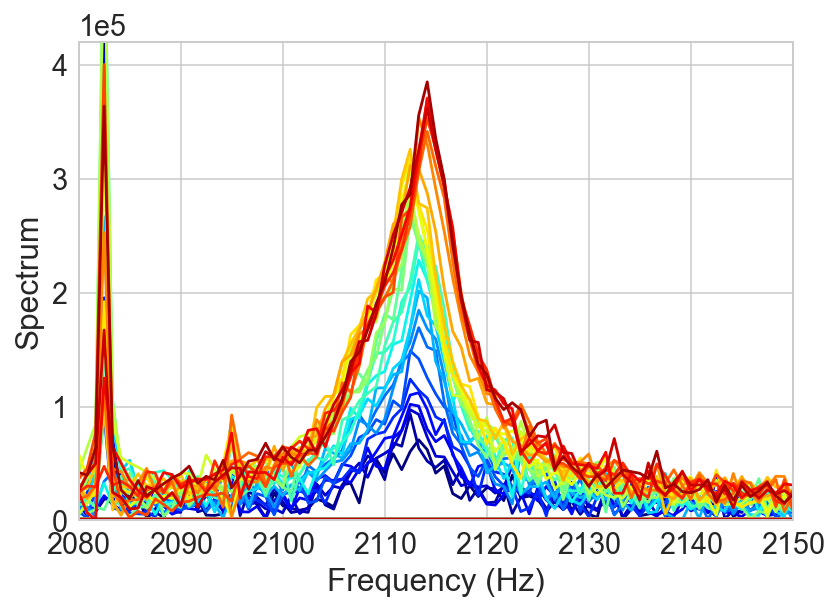

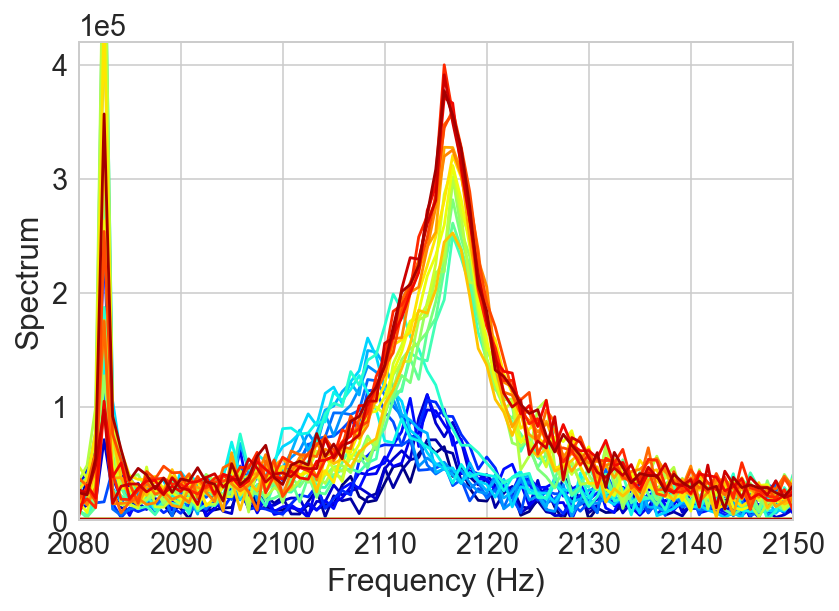

In [6]:
xlims0 = [2080, 2150]
ylims0 = [0, 420000]
plot_ffts(pol_t0, data0, xlims0, ylims0)

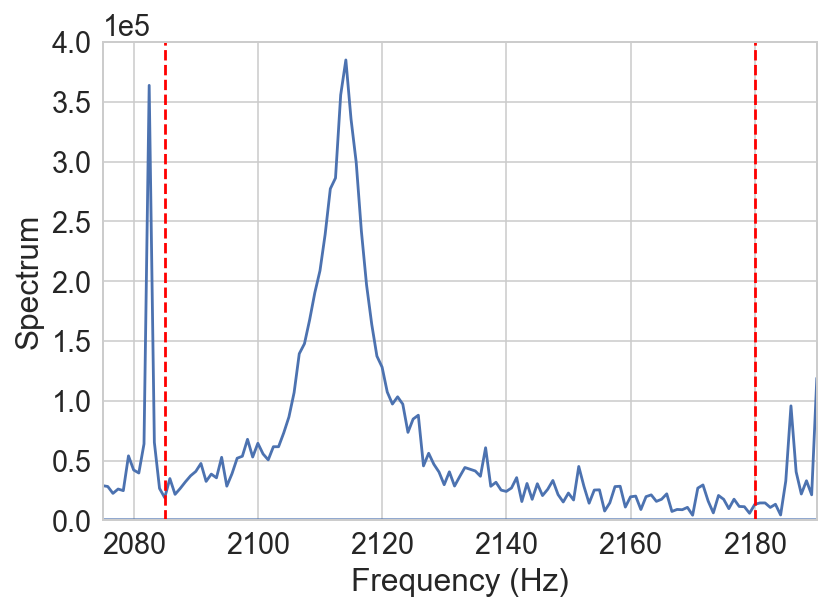

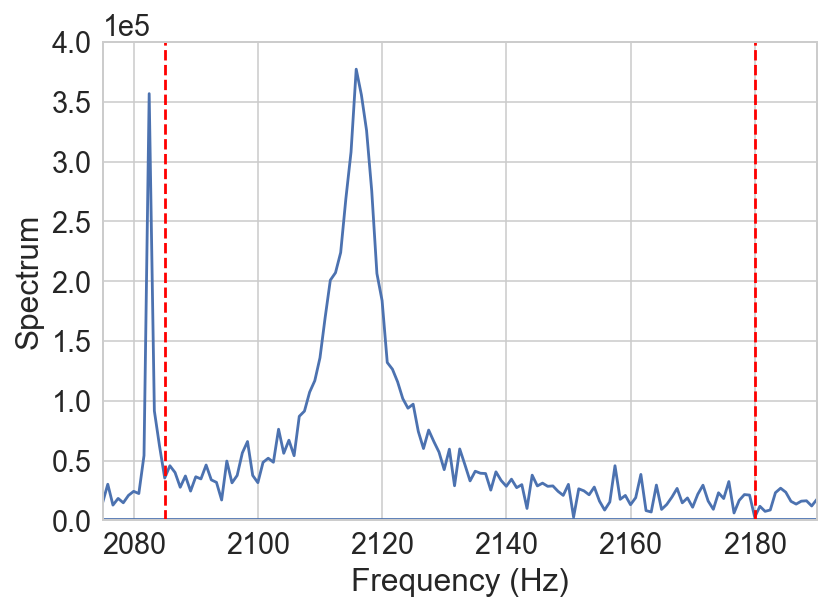

In [7]:
peak_lims0 = [2085, 2180]
ylims = [0, 400000]
plot_peak_lims(pol_t0, data0, peak_lims0, ylims)

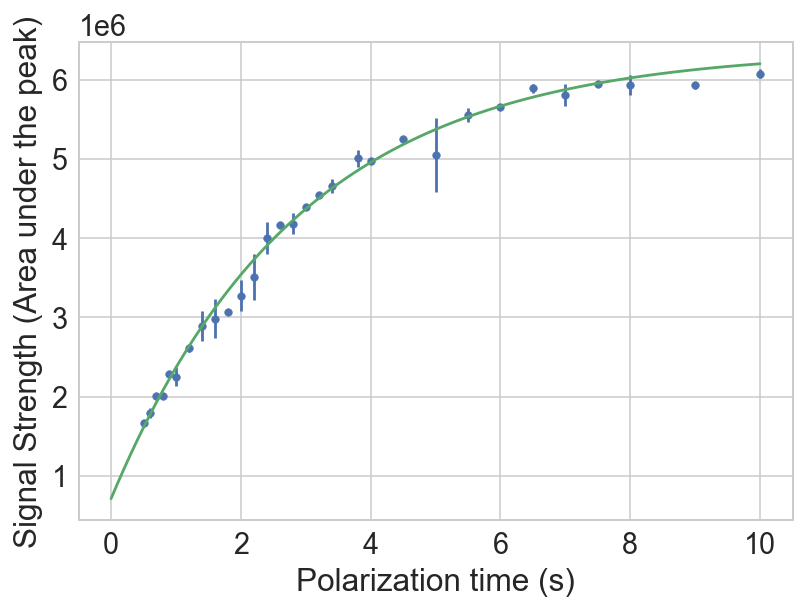

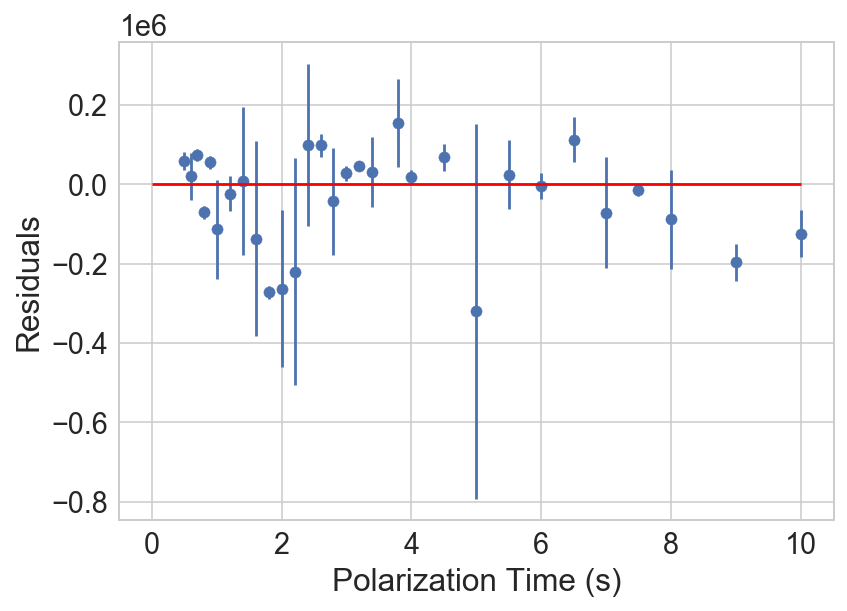

In [8]:
T1_0, uT1_0, chi2_0, popt_0, pcov_0 = \
    get_T1(data0, pol_t0, peak_lims0, p0=[2.9, 7e6, 7e5])

In [9]:
T1_0, uT1_0, chi2_0

(2.8965853213673807, 0.12621049750212696, 15.341970139998258)

## 10.22g salt water

In [10]:
data10, pol_t10 = load_data('./nov15/10*', './nov15/10_22gsaltwaterset1/array.txt')

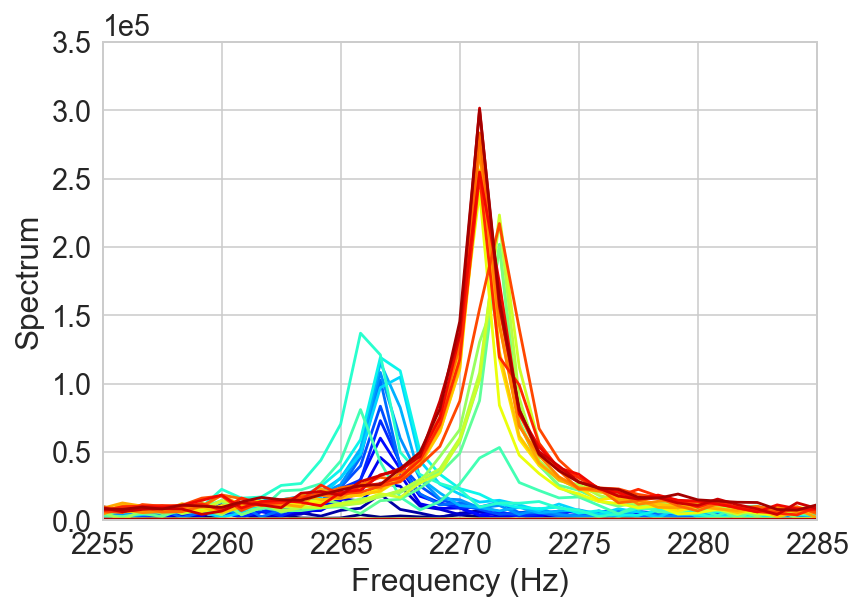

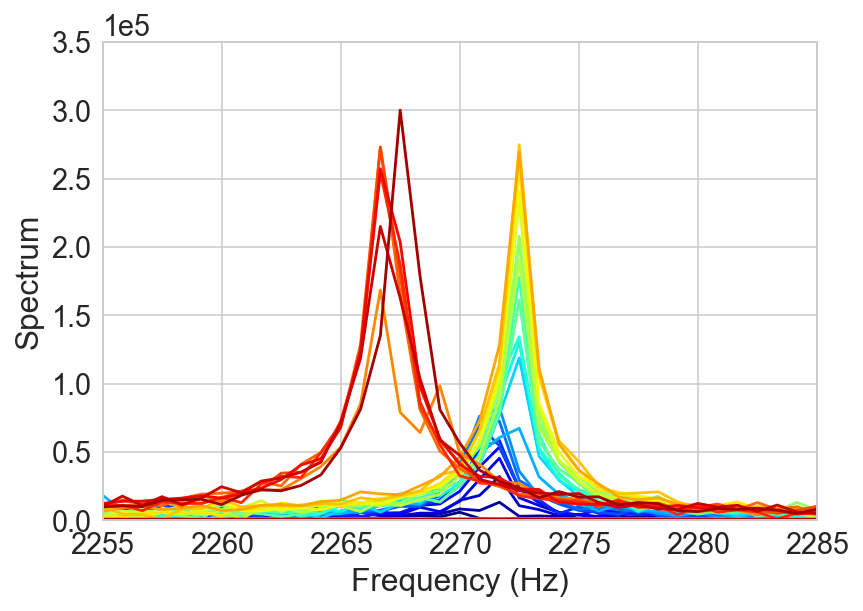

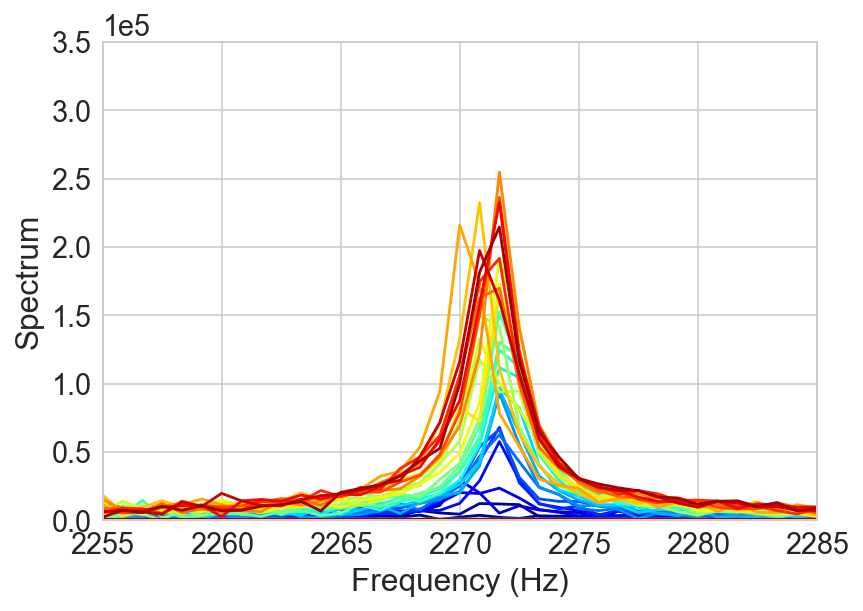

In [11]:
xlims10 = [2255, 2285]
ylims10 = [0, 350000]
plot_ffts(pol_t10, data10, xlims10, ylims10)

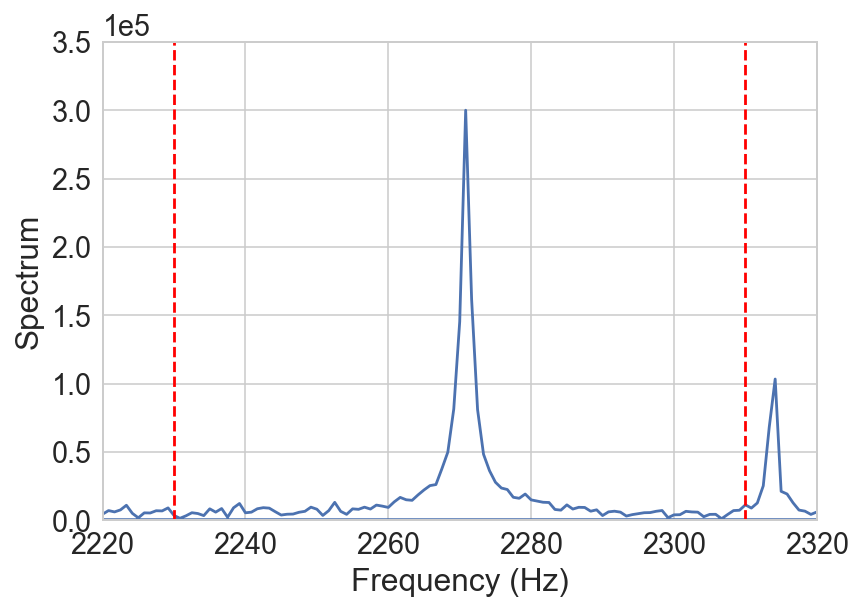

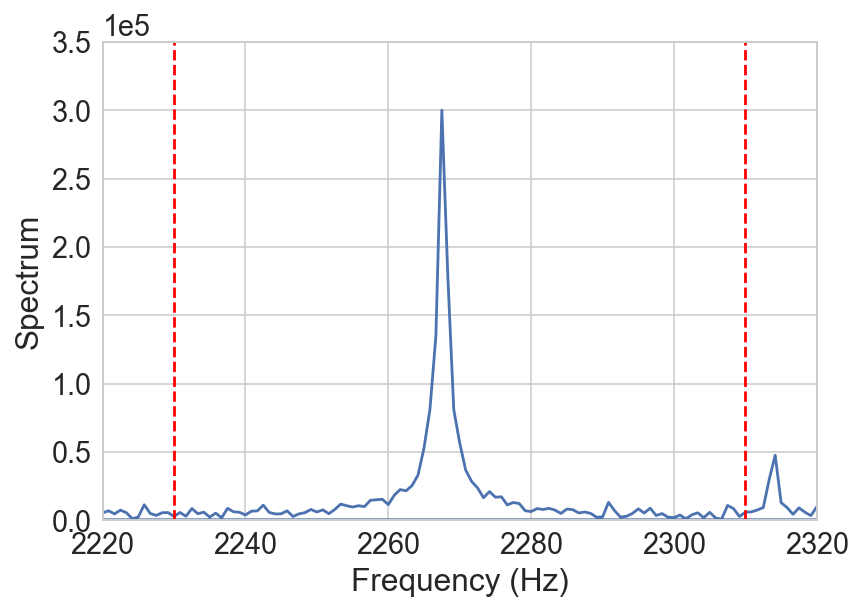

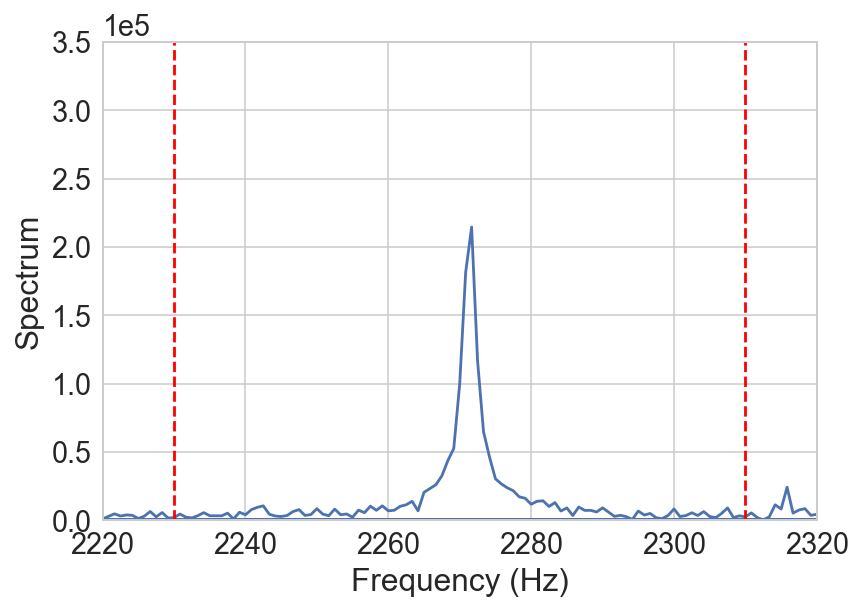

In [12]:
peak_lims10 = [2230, 2310]
ylims10 = [0, 350000]
plot_peak_lims(pol_t10, data10, peak_lims10, ylims10)

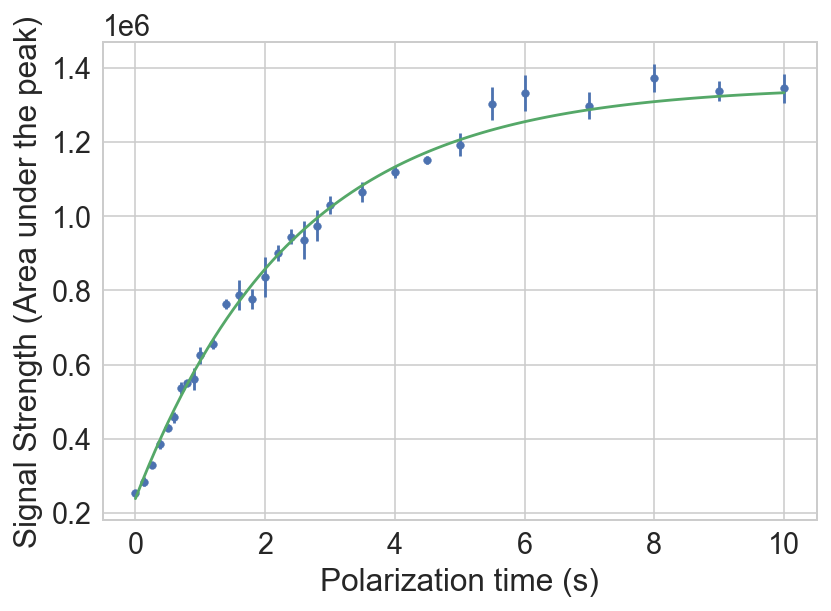

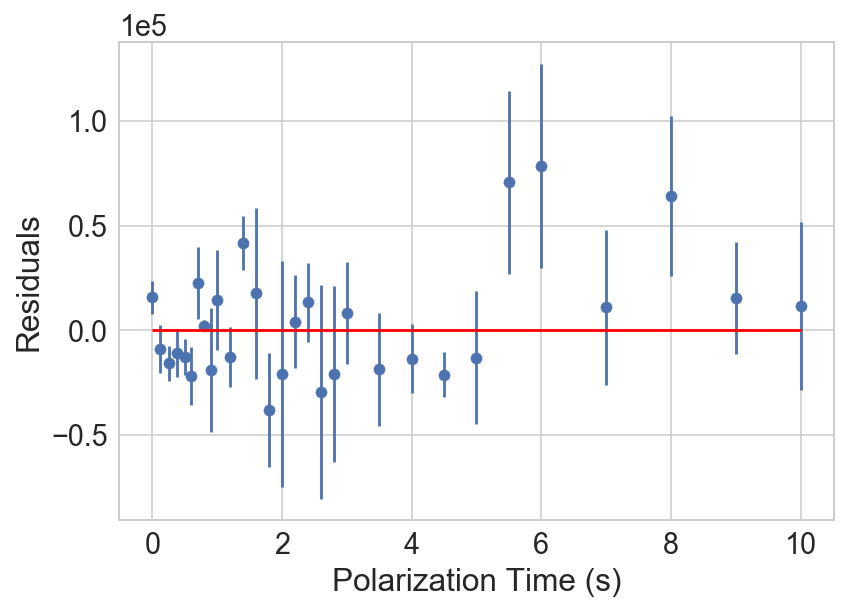

In [13]:
T1_10, uT1_10, chi2_10, popt_10, pcov_10 = \
    get_T1(data10, pol_t10, peak_lims10, p0=[2.5, 1.4e6, 3e5])

In [14]:
T1_10, uT1_10, chi2_10

(2.4617031640052311, 0.091274370953030232, 0.84162170740884035)

## 30.88g salt water

In [15]:
data30, pol_t30 = load_data('./nov15/30*', './nov15/30_88gsaltwaterset1/array.txt')

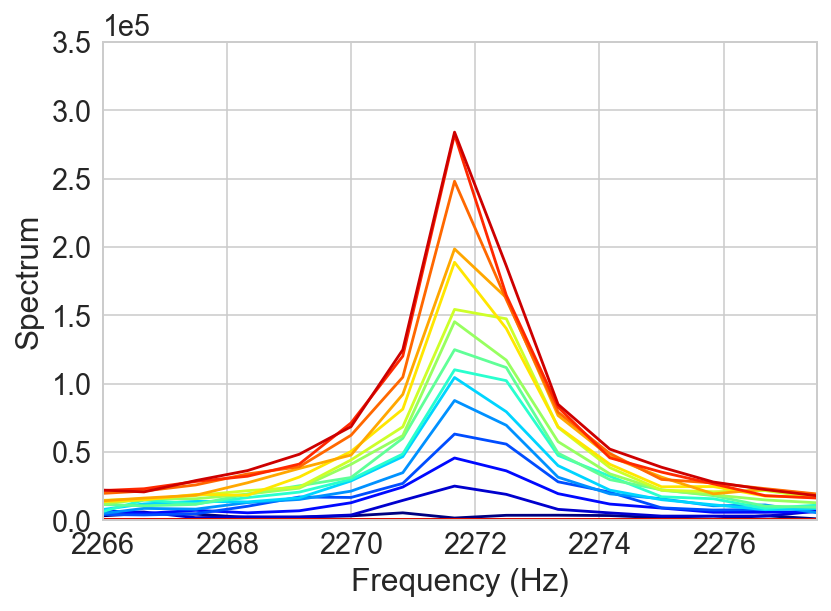

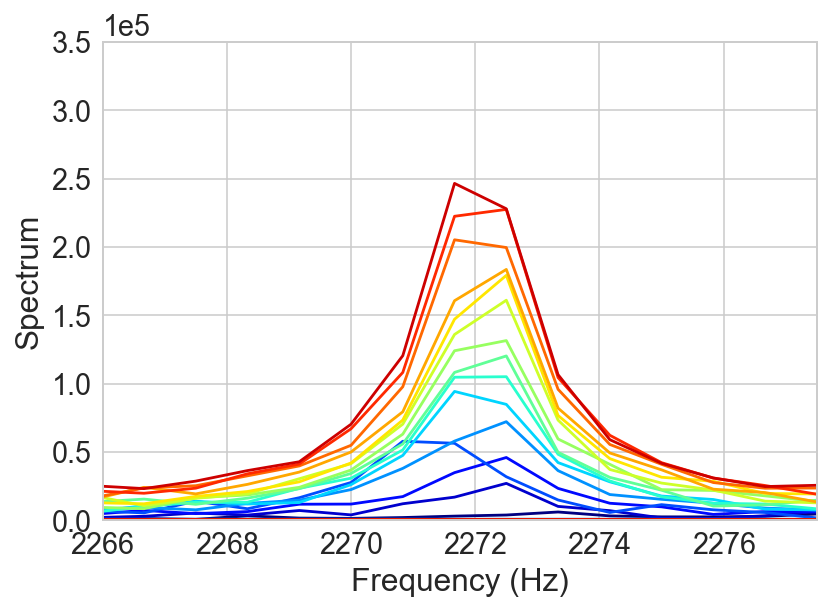

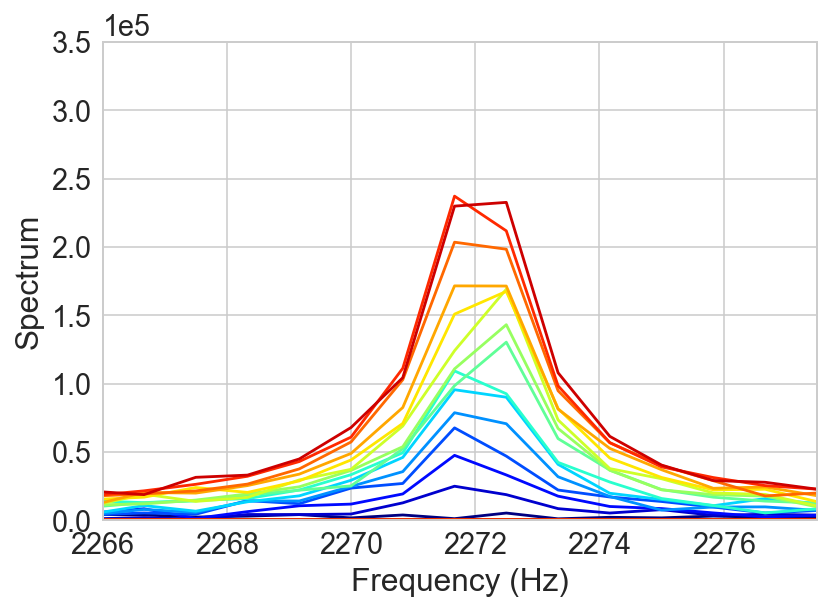

In [16]:
xlims30 = [2266, 2277.5]
ylims30 = [0, 350000]
plot_ffts(pol_t30, data30, xlims30, ylims30)

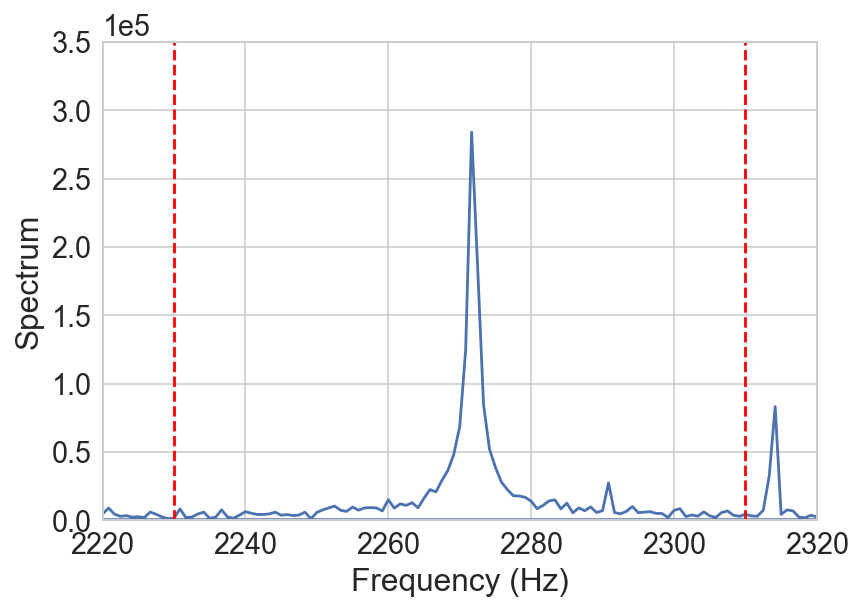

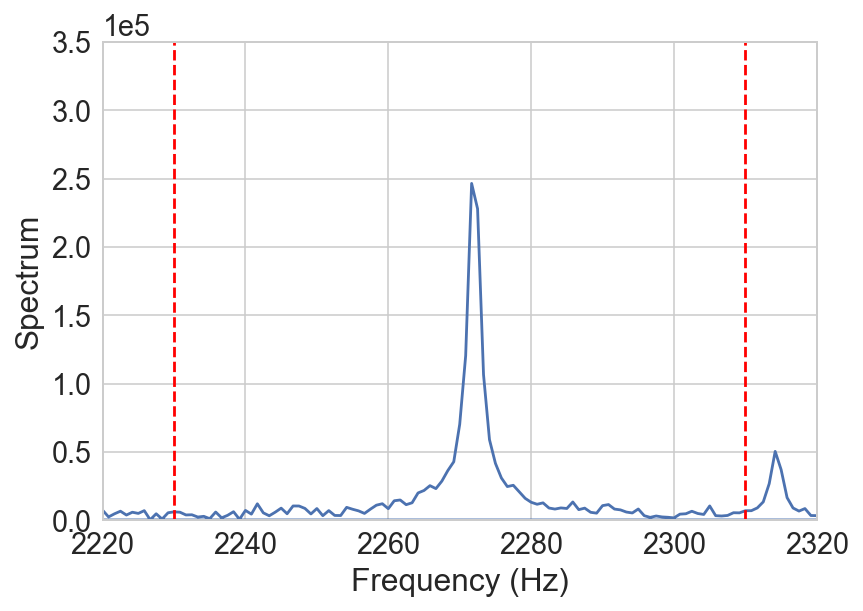

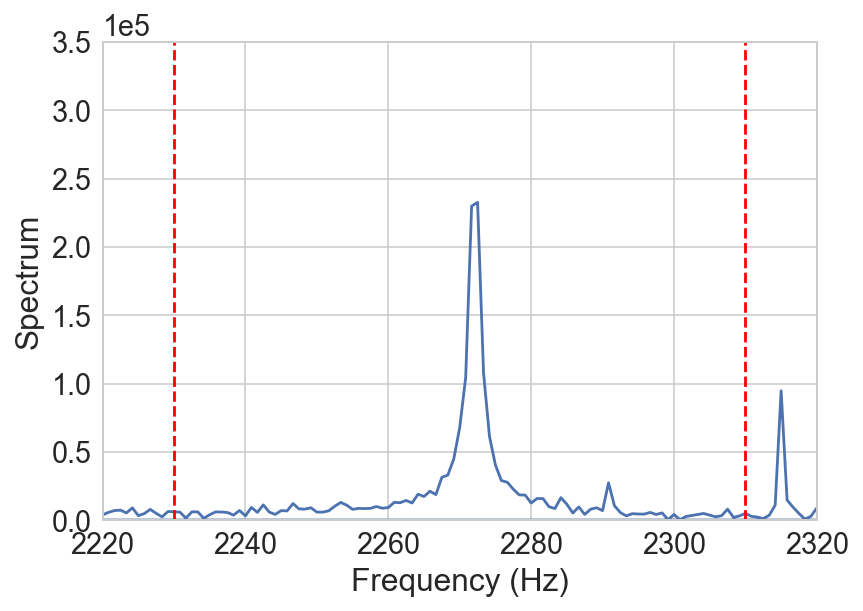

In [17]:
peak_lims30 = [2230, 2310]
ylims30 = [0, 350000]
plot_peak_lims(pol_t30, data30, peak_lims30, ylims30)

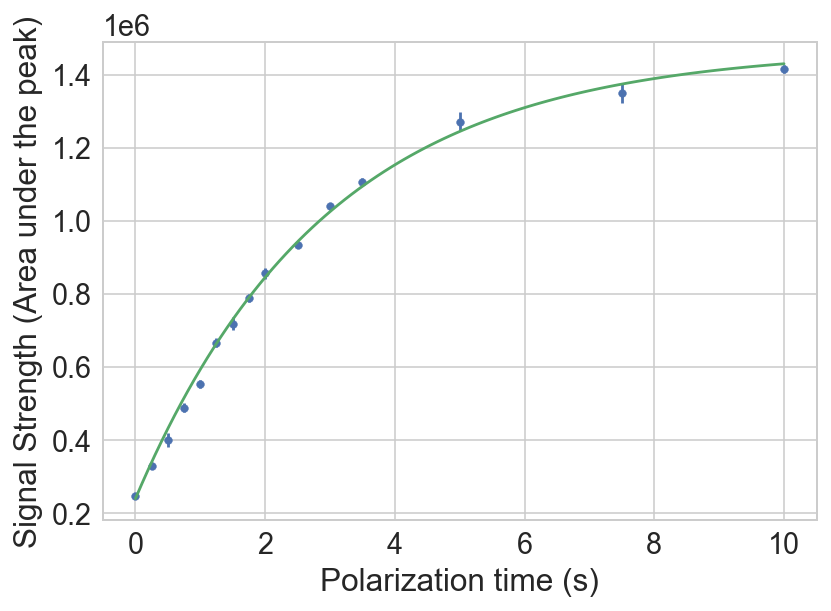

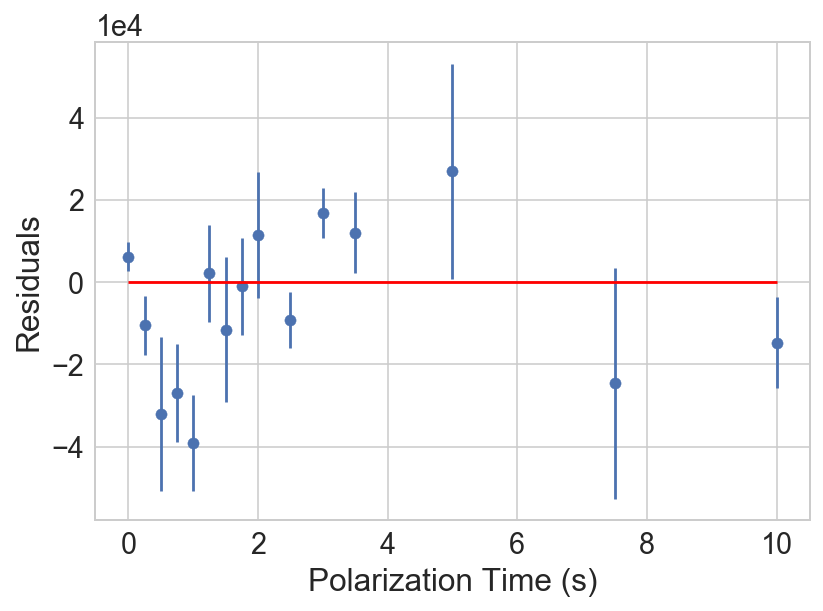

In [18]:
T1_30, uT1_30, chi2_30, popt_30, pcov_30 = \
    get_T1(data30, pol_t30, peak_lims30, p0=[2.8, 1.5e6, 3e5])

In [19]:
T1_30, uT1_30, chi2_30

(2.9565994146111936, 0.10897897240286467, 1.6799250785022168)

## 48.55g of salt

In [20]:
data48, pol_t48 = load_data('./nov15/48*', './nov15/48gsaltwaterset1/array.txt')

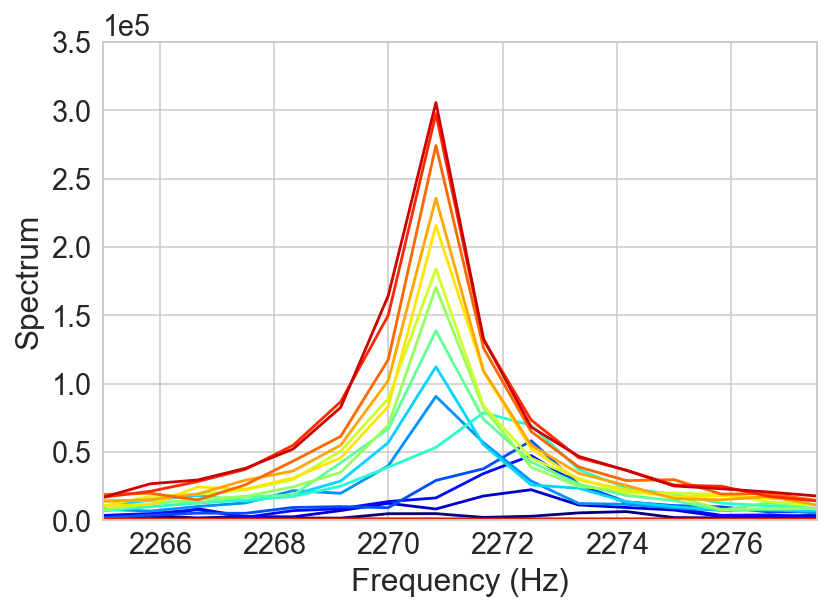

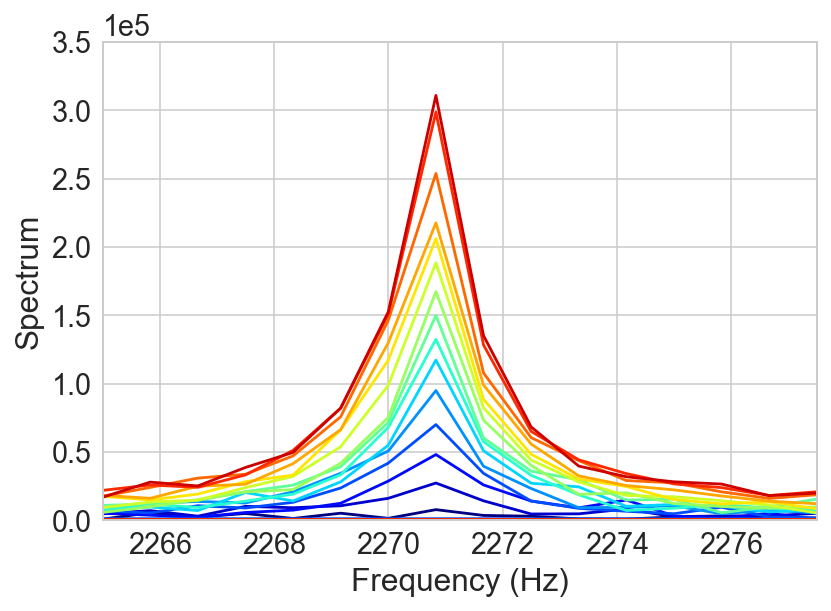

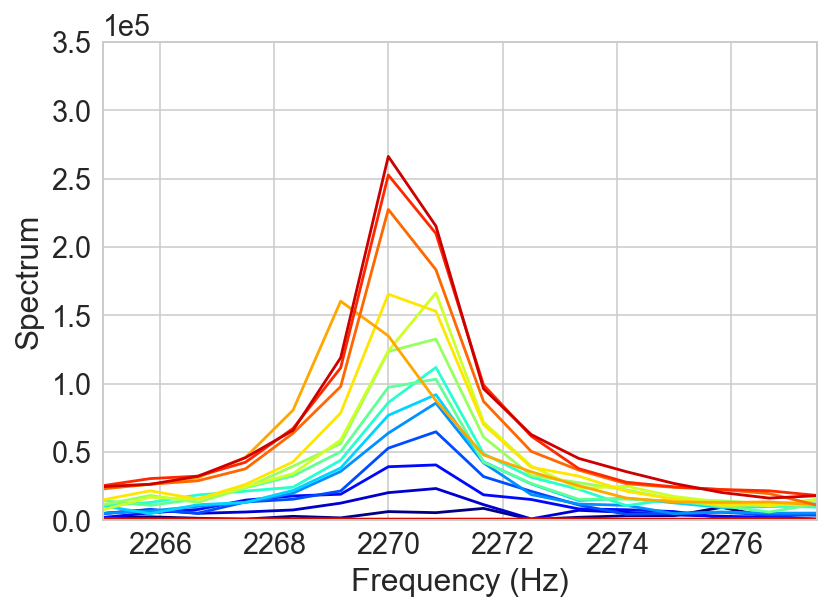

In [21]:
xlims48 = [2265, 2277.5]
ylims48 = [0, 350000]
plot_ffts(pol_t48, data48, xlims48, ylims48)

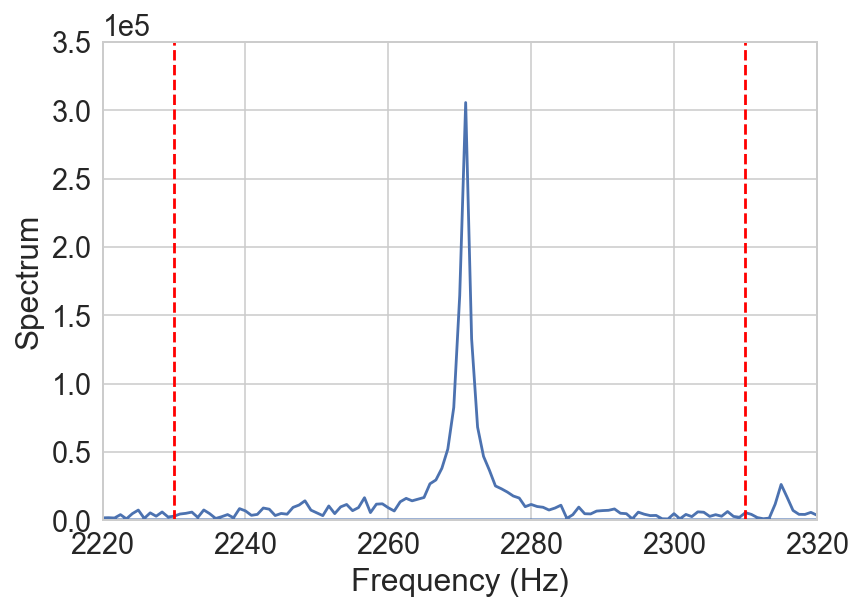

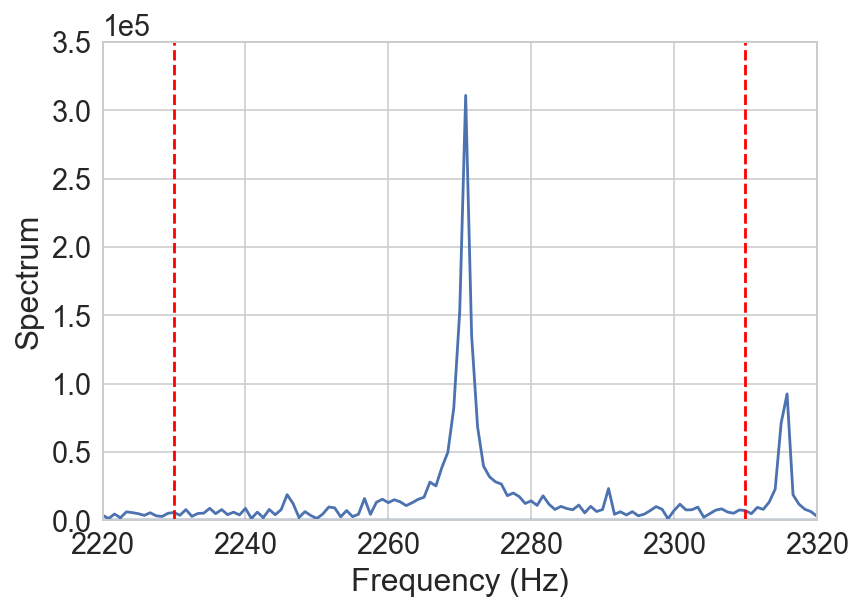

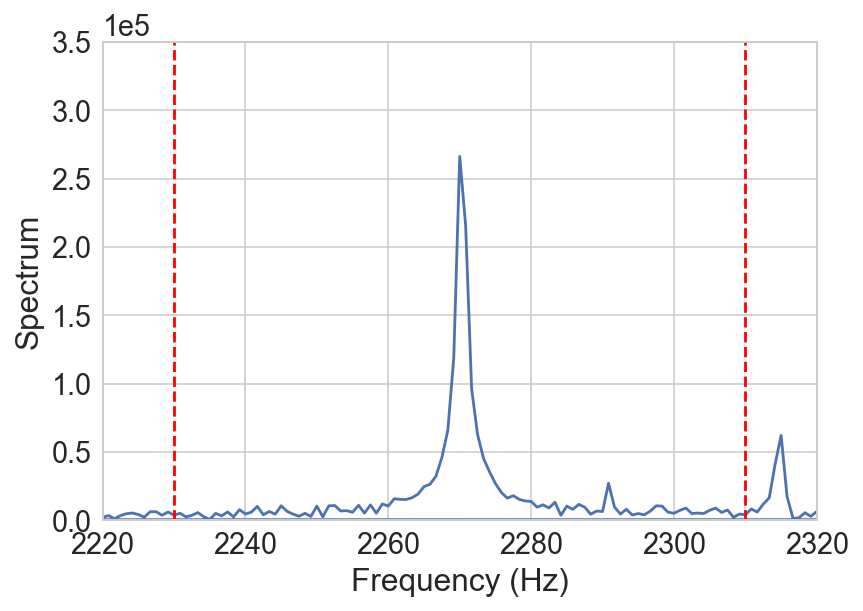

In [22]:
peak_lims48 = [2230, 2310]
ylims30 = [0, 350000]
plot_peak_lims(pol_t48, data48, peak_lims48, ylims48)

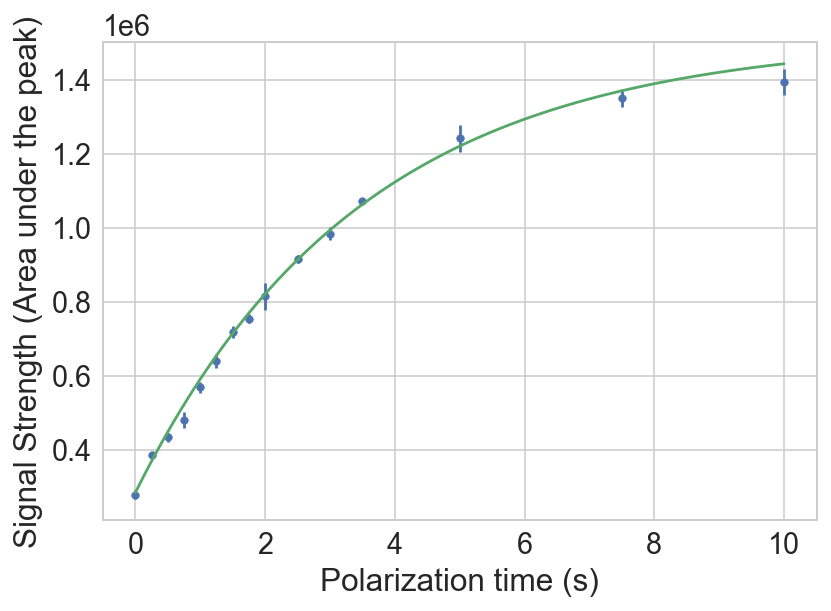

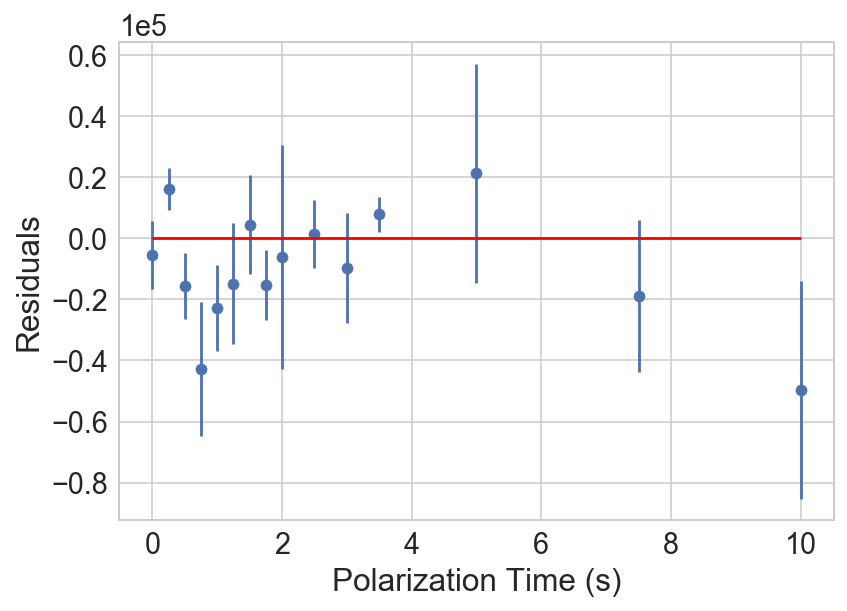

In [23]:
T1_48, uT1_48, chi2_48, popt_48, pcov_48 = \
    get_T1(data48, pol_t48, peak_lims48, p0=[3.4, 1.3e6, 1e5])

In [24]:
T1_48, uT1_48, chi2_48

(3.481578447197176, 0.22017866395888785, 0.90502009304336373)

## Plotting all salt data together

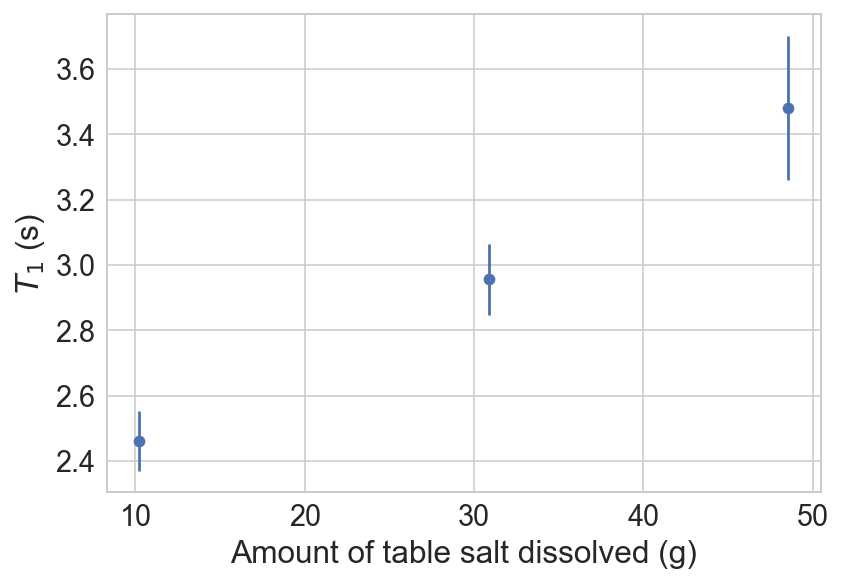

In [25]:
scatter([10.22, 30.88, 48.55], [T1_10,T1_30,T1_48])
errorbar([10.22, 30.88, 48.55], [T1_10,T1_30,T1_48], yerr=[uT1_10,uT1_30,uT1_48], linestyle='none')
ylabel('$T_1$ (s)')
xlabel('Amount of table salt dissolved (g)')

### Attempt a linear fit of the data

In [26]:
def linear_model(x, m, b):
    return m*x + b

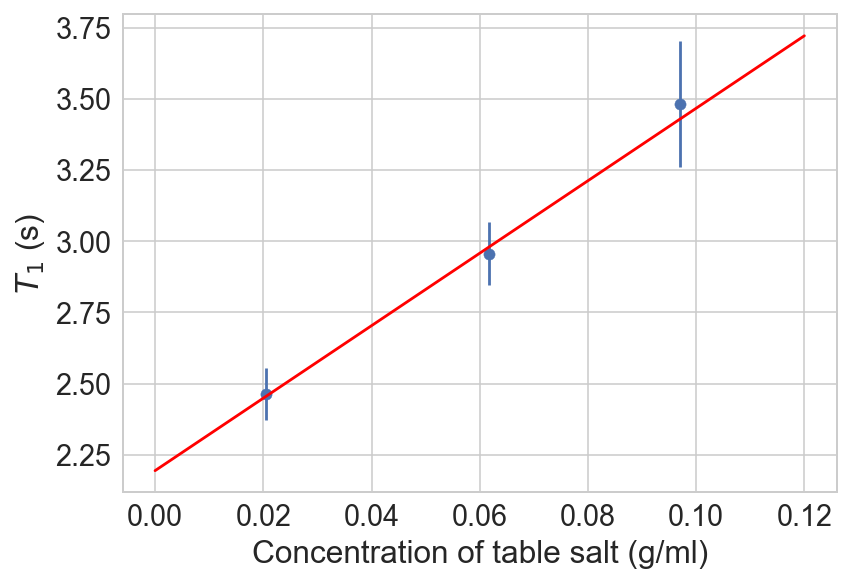

In [27]:
salt_mass = array([10.22, 30.88, 48.55])  # in grams
conc = salt_mass / 500  # concentration of salt in g/ml
T1_salt = [T1_10,T1_30,T1_48]
uT1_salt = [uT1_10,uT1_30,uT1_48]
popt, pcov = curve_fit(linear_model, conc, T1_salt, sigma=uT1_salt, p0=[875, 2000])

scatter(conc, T1_salt)
errorbar(conc, T1_salt, yerr=uT1_salt, linestyle='none')

x = linspace(0, 0.12)
plot(x, linear_model(x, *popt), color='r')
xlabel('Concentration of table salt (g/ml)')
ylabel('$T_1$ (s)')

In [28]:
data_m, pol_m = load_data('./nov22/methanol*', './nov22/methanol_dataset1/array.txt')

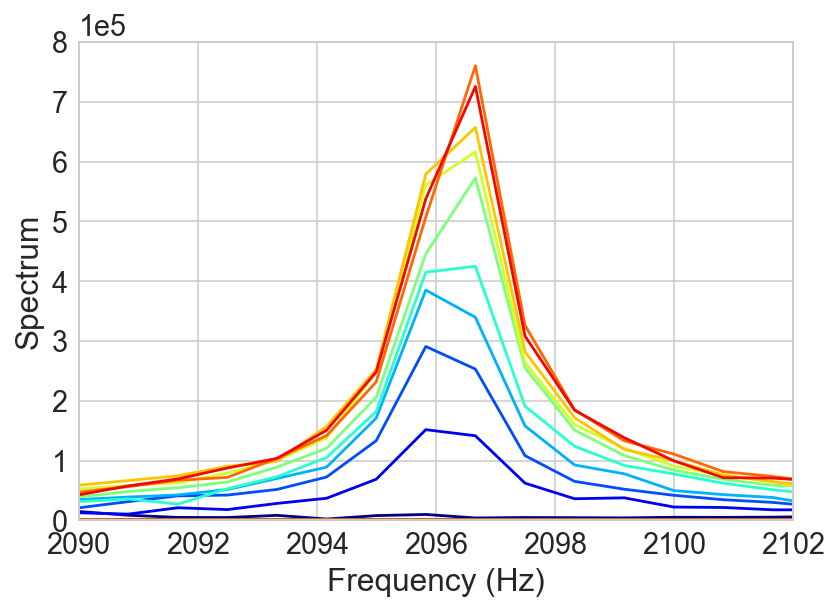

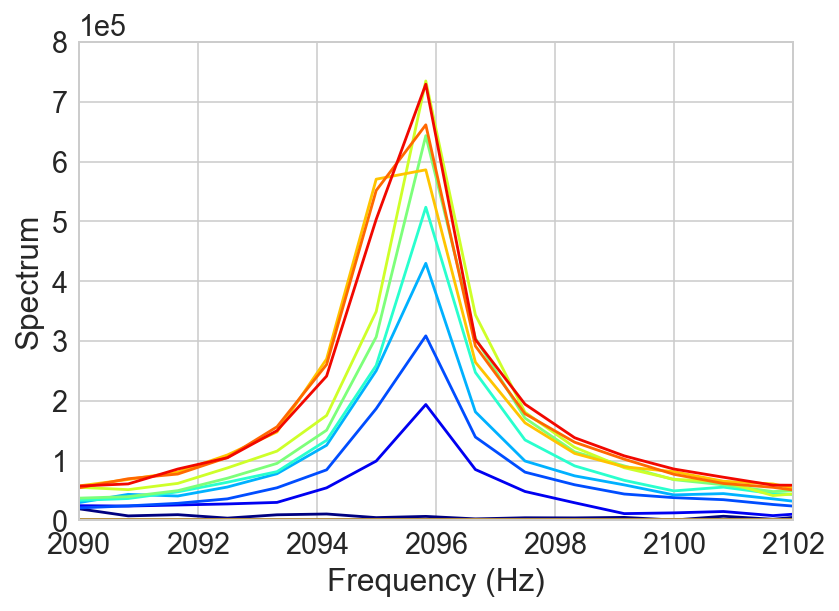

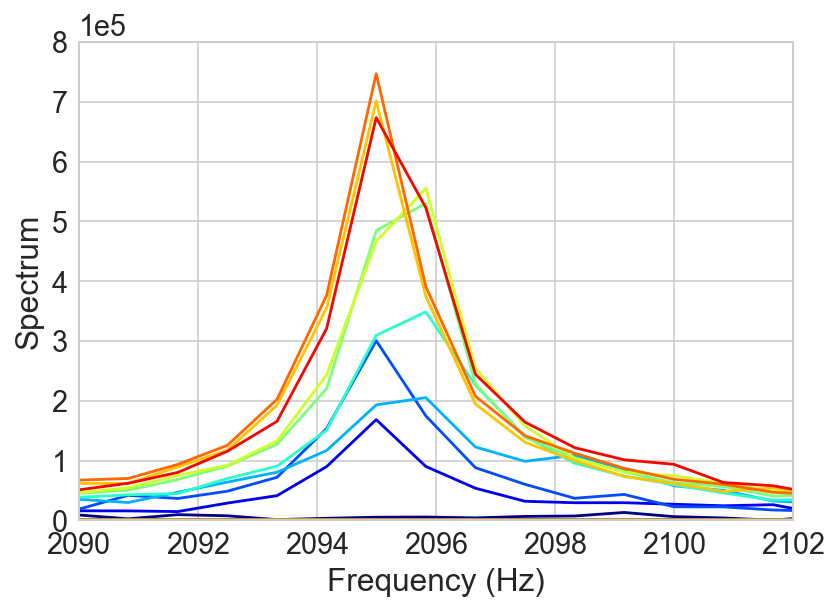

In [29]:
xlims_m = [2090, 2102]
ylims_m = [0, 800000]
plot_ffts(pol_m, data_m, xlims_m, ylims_m)

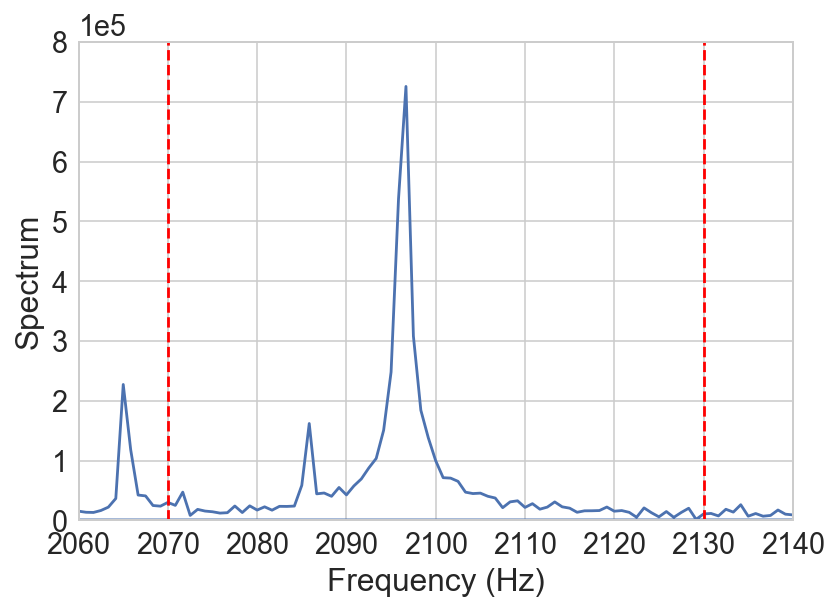

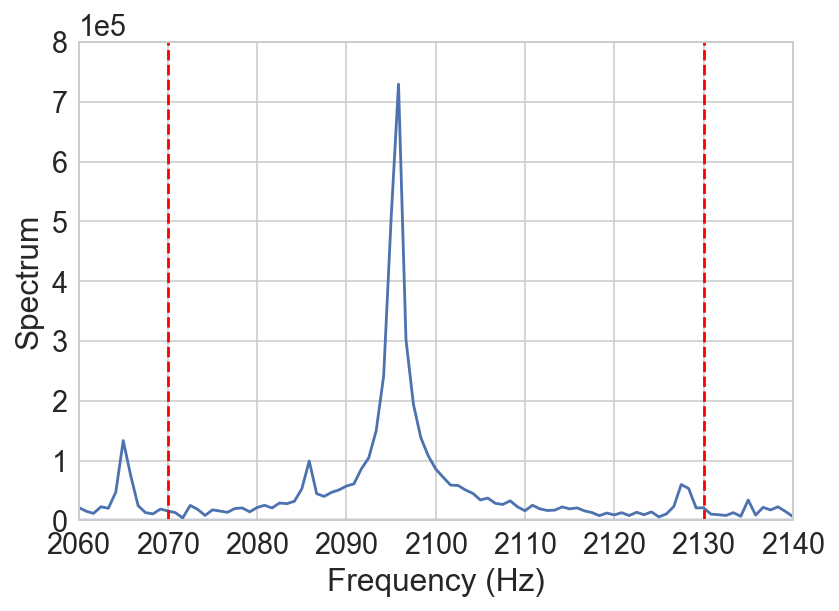

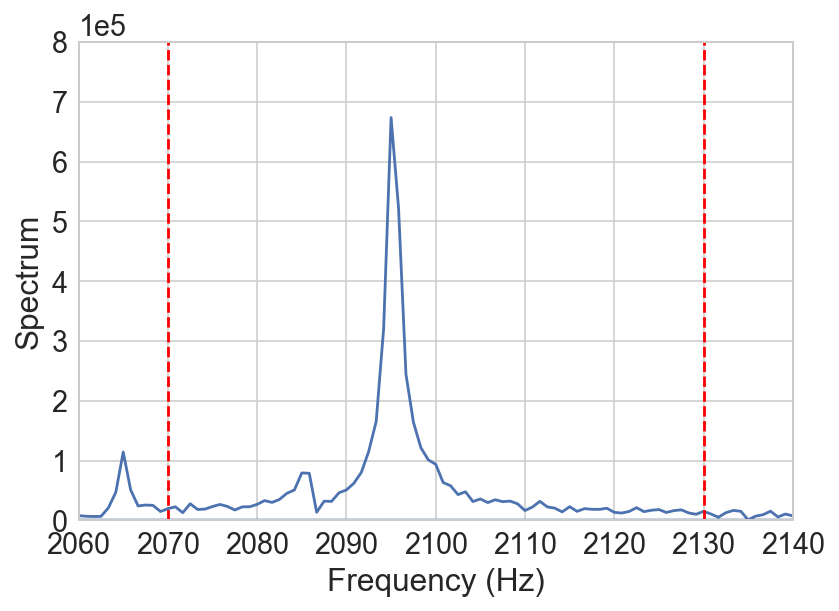

In [30]:
peak_lims_m = [2070, 2130]
ylims_m = [0, 800000]
plot_peak_lims(pol_m, data_m, peak_lims_m, ylims_m)

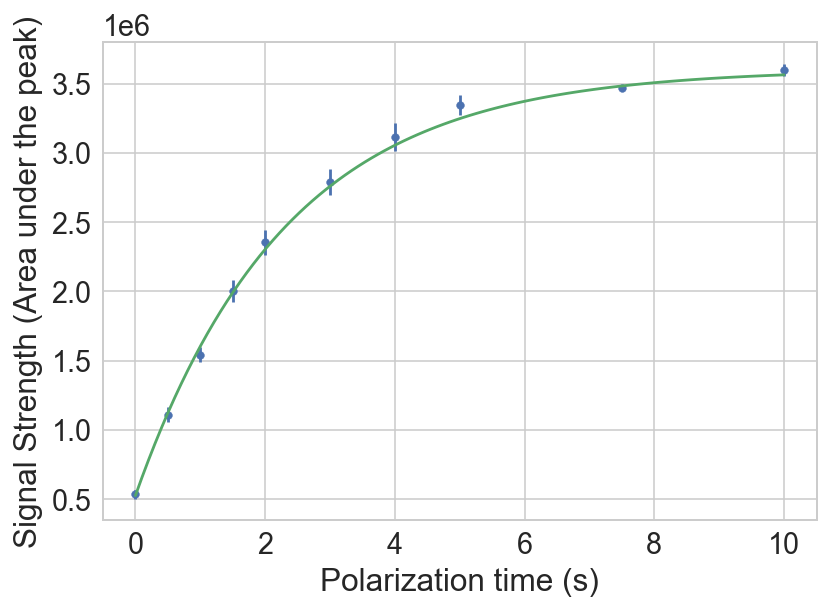

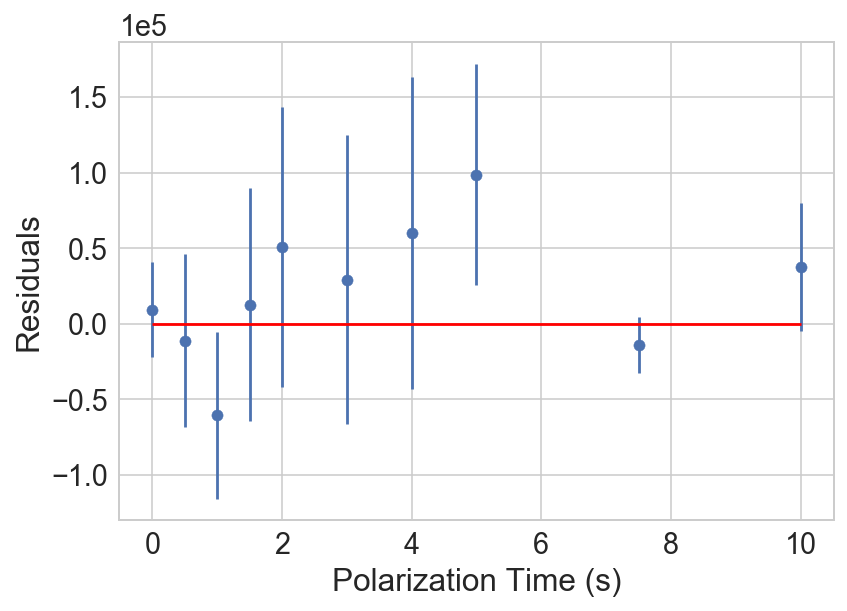

In [31]:
T1_m, uT1_m, chi2_m, popt_m, pcov_m = \
    get_T1(data_m, pol_m, peak_lims_m, p0=[2.3, 3.5e6, 5e5])

In [32]:
T1_m, uT1_m, chi2_m

(2.3218808698003266, 0.092558685611786359, 0.37684243650055033)

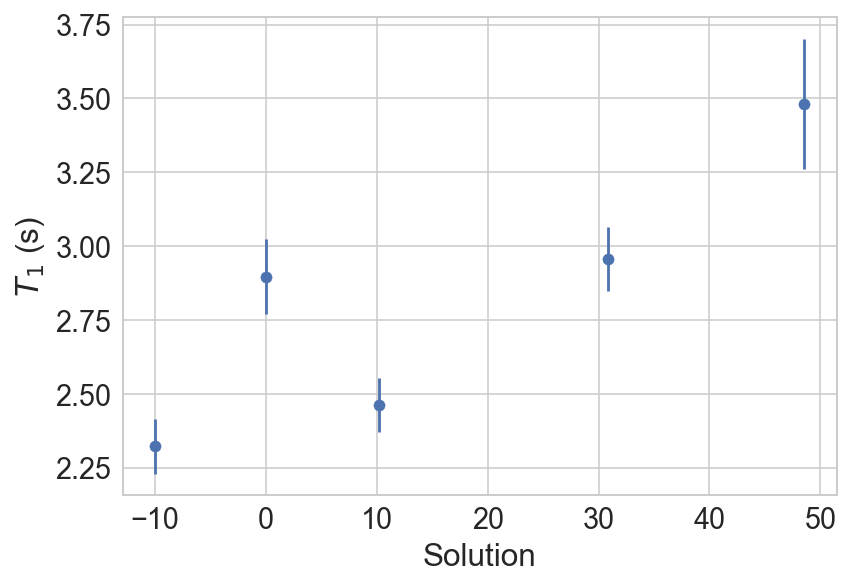

In [33]:
scatter([-10, 0, 10.22, 30.88, 48.55], [T1_m, T1_0, T1_10,T1_30,T1_48])
errorbar([-10, 0, 10.22, 30.88, 48.55], [T1_m, T1_0, T1_10,T1_30,T1_48], yerr=[uT1_m, uT1_0, uT1_10,uT1_30,uT1_48], linestyle='none')
ylabel('$T_1$ (s)')
xlabel('Solution')